In [ ]:
import ssam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import h5py

pixel_per_um = 15.3846 # from BioRxiv paper
um_per_pixel = 1.0 / pixel_per_um

blacklists = ['Cnr1_Hybridization4', 'Plp1_Hybridization4', 'Vtn_Hybridization4',
              'Klk6_Hybridization5', 'Lum_Hybridization9', 'Tbr1_Hybridization11']

with h5py.File("./data/raw/mRNA_coords_raw_counting.hdf5", 'r') as f:
    # Extract gene names (keys)
    gene_names = list(f.keys())
    # Extract x, y coordinates for each gene and store them along with the gene name
    data_list = []
    for gene in gene_names:
        if gene in blacklists:
            continue
        xx, yy = f[gene][:].T
        gene = gene.split("_")[0]
        
        if gene == 'Tmem6':
            gene = 'Tmem2'
        elif gene == 'Kcnip':
            gene = 'Kcnip2'

        for x, y in zip(xx, yy):
            data_list.append([gene, x * um_per_pixel, y * um_per_pixel])

# Create a pandas DataFrame
df = pd.DataFrame(data_list, columns=['gene', 'x', 'y']).set_index('gene')

In [10]:
ds = ssam.SSAMDataset("spatialdata.zarr")
analysis = ssam.SSAMAnalysis(ds, ncores=40, verbose=True)

In [ ]:
analysis.run_kde(df, width=1640, height=3368, re_run=True)

Running KDE for gene Acta2...
Saving KDE for gene Acta2...
Running KDE for gene Aldoc...


In [13]:
#default parameter
analysis.find_localmax(search_size=3)

Found 11443 local max vectors.


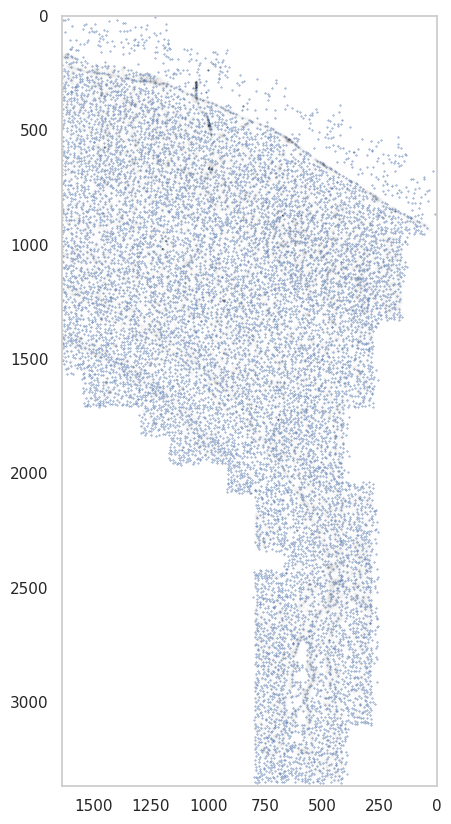

In [14]:
plt.figure(figsize=[5, 10])
ds.plot_l1norm(cmap="Greys", rotate=2)
ds.plot_localmax(rotate=2, s=0.1)
plt.show()

In [15]:
analysis.normalize_vectors()

Normalizing vectors...
Normalizing vector field...
Processing chunk 1 (of 3)...
Processing chunk 2 (of 3)...
Processing chunk 3 (of 3)...


In [16]:
analysis.scale_vectors()

Scaling data...
Processing chunk 1 (of 3)...
Processing chunk 2 (of 3)...
Processing chunk 3 (of 3)...


In [17]:
analysis.cluster_vectors(resolution=3)

Found 39 clusters


In [18]:
ds.run_umap()

/home/ng4812/miniconda3/envs/ome/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [19]:
ds.run_tsne()

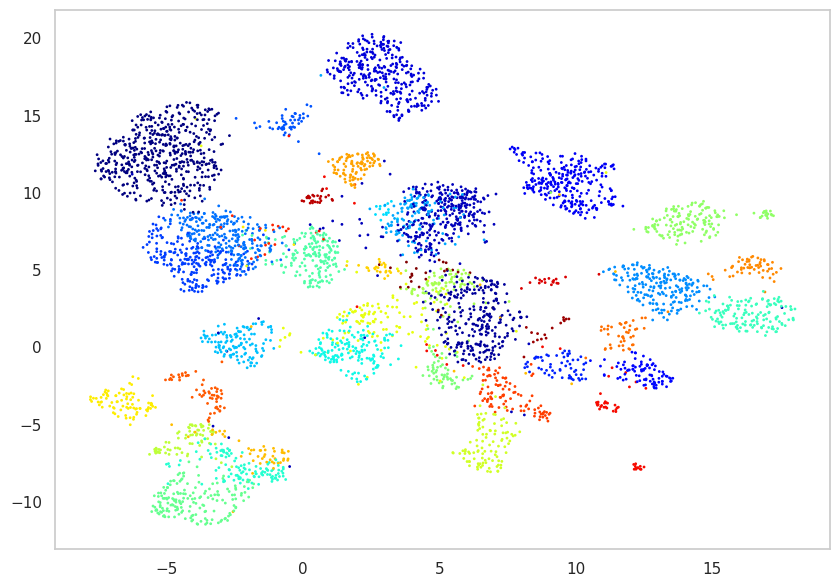

In [20]:
plt.figure(figsize=[10, 7])
ds.plot_umap(s=1)

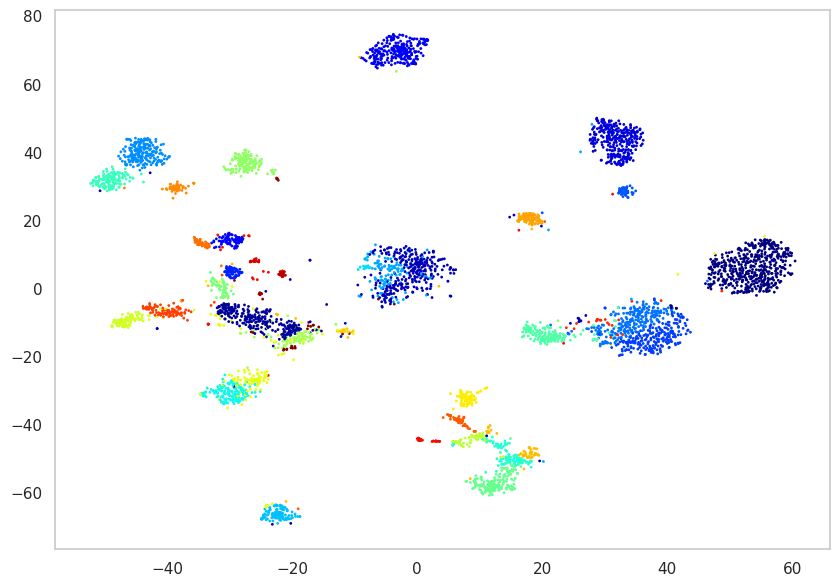

In [21]:
plt.figure(figsize=[10, 7])
ds.plot_tsne(s=1)

In [22]:
analysis.map_celltypes()

Generating cell-type map for centroid #0...
Processing chunk (0/2)...
Processing chunk (1/2)...
Generating cell-type map for centroid #1...
Processing chunk (0/2)...


Processing chunk (1/2)...
Generating cell-type map for centroid #2...
Processing chunk (0/2)...
Processing chunk (1/2)...
Generating cell-type map for centroid #3...
Processing chunk (0/2)...
Processing chunk (1/2)...
Generating cell-type map for centroid #4...
Processing chunk (0/2)...
Processing chunk (1/2)...
Generating cell-type map for centroid #5...
Processing chunk (0/2)...
Processing chunk (1/2)...
Generating cell-type map for centroid #6...
Processing chunk (0/2)...
Processing chunk (1/2)...
Generating cell-type map for centroid #7...
Processing chunk (0/2)...
Processing chunk (1/2)...
Generating cell-type map for centroid #8...
Processing chunk (0/2)...
Processing chunk (1/2)...
Generating cell-type map for centroid #9...
Processing chunk (0/2)...
Processing chunk (1/2)...
Generating cell-type map for centroid #10...
Processing chunk (0/2)...
Processing chunk (1/2)...
Generating cell-type map for centroid #11...
Processing chunk (0/2)...
Processing chunk (1/2)...
Generating c

In [23]:
analysis.filter_celltypemaps(min_norm=0.3, min_r=0.6)

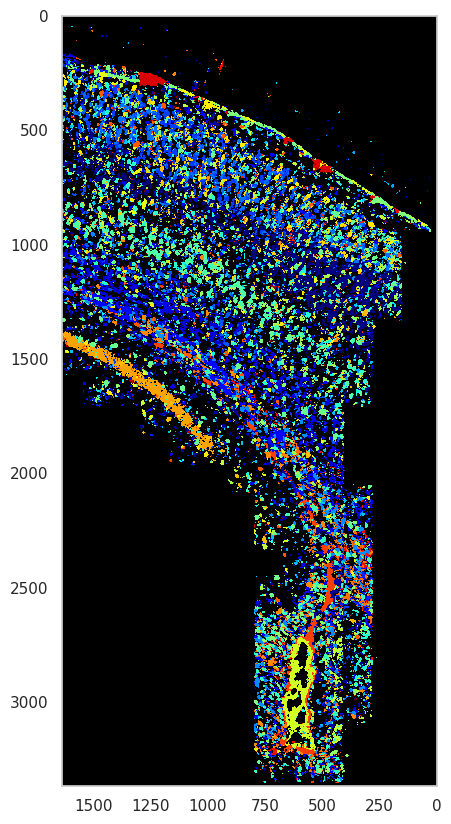

In [24]:
plt.figure(figsize=[5, 10])
ds.plot_celltypes_map(rotate=2)

In [25]:
import loompy
osmfish_loom = loompy.connect("./data/raw/osmFISH_SScortex_mouse_all_cells.loom", mode="r")

/home/ng4812/miniconda3/envs/ome/lib/python3.11/site-packages/loompy/bus_file.py:67: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/ng4812/miniconda3/envs/ome/lib/python3.11/site-packages/loompy/bus_file.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/ng4812/miniconda3/envs/ome/lib/python3.11/site-packages/loompy/bus_file.py:101: NumbaD

In [26]:
osmfish_loom

,,,CellID,778,1409,3642,1302,1285,769,1466,5870,1392,5682,...
,,,ClusterID,18,18,18,18,18,18,18,18,18,18,...
,,,ClusterName,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,...
,,,Region,Layer 6,Internal Capsule Caudoputamen,Layer 4,Internal Capsule Caudoputamen,Internal Capsule Caudoputamen,Layer 4,White matter,Layer 4,Internal Capsule Caudoputamen,Layer 2-3 medial,...
,,,Total_molecules,390,279,405,132,276,491,87,518,239,210,...
,,,Valid,1,1,1,1,1,1,1,1,1,1,...
,,,X,18171.230942376023,19838.08089469819,11247.433714967248,19253.231298951596,19612.52746706525,18374.295795684622,18132.019761954383,4197.789280405199,20452.07268496869,3757.866348635427,...
,,,Y,24590.795274569497,6456.144686569438,36626.892415142735,7389.731237290762,10793.160565894526,26286.856653908053,2115.0370273875524,39465.355902861425,6184.981168761355,46281.16716625502,...
,,,_tSNE_1,-58.13238525390625,-54.57238006591797,-61.572853088378906,-57.90510559082031,-59.13956832885742,-66.86224365234375,-54.061279296875,-59.923431396484375,-57.11332702636719,-64.76947021484375,...
,,,_tSNE_2,5.219181060791016,12.113470077514648,-1.1853644847869873,9.22524356842041,7.926783084869385,-1.7665001153945923,6.972393035888672,-3.7398080825805664,8.048858642578125,5.166342735290527,...
,,,size_pix,60911.0,31781.0,44143.0,18163.0,37353.0,41014.0,9660.0,42376.0,34809.0,23922.0,...


In [27]:
from sklearn.preprocessing import normalize, scale
from scipy.stats import median_test
import numpy as np

osmfish_genes = list(osmfish_loom.row_attrs['Gene'])
osmfish_gene_indices = [osmfish_genes.index(gene) for gene in ds.genes]
osmfish_clusters = osmfish_loom.col_attrs['ClusterName']
osmfish_data = osmfish_loom[:,:].T[:, osmfish_gene_indices][osmfish_clusters != "Excluded", :]
osmfish_clusters = osmfish_clusters[osmfish_clusters != "Excluded"]
osmfish_uniq_labels = np.unique(osmfish_clusters)

In [28]:
ds.vf_norm

dask.array<from-zarr, shape=(1640, 3368, 1), dtype=float32, chunksize=(205, 842, 1), chunktype=numpy.ndarray>

In [29]:
osmfish_genes

['Gad2',
 'Slc32a1',
 'Crhbp',
 'Cnr1',
 'Vip',
 'Cpne5',
 'Pthlh',
 'Crh',
 'Tbr1',
 'Lamp5',
 'Rorb',
 'Syt6',
 'Kcnip2',
 'Aldoc',
 'Gfap',
 'Serpinf1',
 'Mfge8',
 'Sox10',
 'Plp1',
 'Pdgfra',
 'Bmp4',
 'Itpr2',
 'Tmem2',
 'Ctps',
 'Anln',
 'Mrc1',
 'Hexb',
 'Ttr',
 'Foxj1',
 'Vtn',
 'Flt1',
 'Apln',
 'Acta2']

In [30]:
for gene in ds.genes:
    print(gene, osmfish_genes.index(gene))

Acta2 32
Aldoc 13
Anln 24
Apln 31
Bmp4 20
Cnr1 3
Cpne5 5
Crh 7
Crhbp 2
Ctps 23
Flt1 30
Foxj1 28
Gad2 0
Gfap 14
Hexb 26
Itpr2 21
Kcnip2 12
Lamp5 9
Mfge8 16
Mrc1 25
Pdgfra 19
Plp1 18
Pthlh 6
Rorb 10
Serpinf1 15
Slc32a1 1
Sox10 17
Syt6 11
Tbr1 8
Tmem2 22
Ttr 27
Vip 4
Vtn 29


In [31]:
analysis.transfer_cluster_labels(osmfish_data, osmfish_clusters, size_after_normalization=1e4)

In [32]:
ds.transferred_cluster_labels, ds.transferred_cluster_correlations

(array(['Pyramidal L3-4', 'Astrocyte Mfge8', 'Inhibitory Pthlh',
        'Pyramidal L6', 'Oligodendrocyte Precursor cells',
        'Astrocyte Gfap', 'Astrocyte Gfap', 'Pyramidal L2-3',
        'Pyramidal L5', 'Pyramidal L2-3 L5', 'Oligodendrocyte Mature',
        'Inhibitory Pthlh', 'Microglia', 'Inhibitory CP', 'Endothelial',
        'Inhibitory CP', 'Oligodendrocyte MF', 'Pyramidal L2-3 L5',
        'Inhibitory Crhbp', 'Astrocyte Gfap', 'Oligodendrocyte COP',
        'Astrocyte Mfge8', 'Inhibitory IC', 'Ependymal', 'Endothelial',
        'Inhibitory Vip', 'Astrocyte Mfge8', 'Inhibitory Kcnip2',
        'Hippocampus', 'Oligodendrocyte NF', 'Astrocyte Gfap',
        'Inhibitory Cnr1', 'Ependymal', 'Pyramidal L2-3 L5',
        'Astrocyte Gfap', 'Astrocyte Gfap', 'Astrocyte Mfge8',
        'Astrocyte Mfge8', 'Astrocyte Mfge8'], dtype=object),
 array([0.81497316, 0.64769585, 0.49141134, 0.76032507, 0.7035034 ,
        0.63212112, 0.63157552, 0.75151354, 0.73763375, 0.70953472,
        0.

In [33]:
osmfish_ref_colors = {
    "Inhibitory CP": "#9b067d",
    "Inhibitory Crhbp": "#9805cc",
    "Inhibitory Cnr1": "#ca4479",
    "Inhibitory IC": "#ff49b0",
    "Inhibitory Kcnip2": "#af7efe",
    "Inhibitory Pthlh": "#4e14a6",
    "Inhibitory Vip": "#7759a4",
    "Pyramidal Cpne5": "#3e4198",
    "Pyramidal L2-3": "#0ab4e4",
    "Pyramidal L2-3 L5": "#1e6a87",
    "Pyramidal Kcnip2": "#6787d6",
    "Pyramidal L3-4": "#004dba",
    "pyramidal L4": "#78edff",
    "Pyramidal L5": "#0a9fb4",
    "Pyramidal L6": "#027fd0",
    "Hippocampus": "#004b71",
    "Astrocyte Gfap": "#de4726",
    "Astrocyte Mfge8": "#f69149",
    "Oligodendrocyte Precursor cells": "#b3ee3d",
    "Oligodendrocyte COP": "#5dd73d",
    "Oligodendrocyte NF": "#64a44e",
    "Oligodendrocyte MF": "#2f7449",
    "Oligodendrocyte Mature": "#285528",
    "Perivascular Macrophages": "#762a14",
    "Microglia": "#a7623d",
    "C. Plexus": "#21b183",
    "Ependymal": "#fadf0b",
    "Pericytes": "#f8c495",
    "Endothelial": "#f81919",
    "Endothelial 1": "#f05556",
    "Vascular Smooth Muscle": "#aec470",
}
osmfish_colors = [osmfish_ref_colors[cl] for cl in osmfish_uniq_labels]

In [34]:
ds.transferred_cluster_labels

array(['Pyramidal L3-4', 'Astrocyte Mfge8', 'Inhibitory Pthlh',
       'Pyramidal L6', 'Oligodendrocyte Precursor cells',
       'Astrocyte Gfap', 'Astrocyte Gfap', 'Pyramidal L2-3',
       'Pyramidal L5', 'Pyramidal L2-3 L5', 'Oligodendrocyte Mature',
       'Inhibitory Pthlh', 'Microglia', 'Inhibitory CP', 'Endothelial',
       'Inhibitory CP', 'Oligodendrocyte MF', 'Pyramidal L2-3 L5',
       'Inhibitory Crhbp', 'Astrocyte Gfap', 'Oligodendrocyte COP',
       'Astrocyte Mfge8', 'Inhibitory IC', 'Ependymal', 'Endothelial',
       'Inhibitory Vip', 'Astrocyte Mfge8', 'Inhibitory Kcnip2',
       'Hippocampus', 'Oligodendrocyte NF', 'Astrocyte Gfap',
       'Inhibitory Cnr1', 'Ependymal', 'Pyramidal L2-3 L5',
       'Astrocyte Gfap', 'Astrocyte Gfap', 'Astrocyte Mfge8',
       'Astrocyte Mfge8', 'Astrocyte Mfge8'], dtype=object)

### 8-3. 가져온 색을 써서 셀 타입 맵 다시 그리기

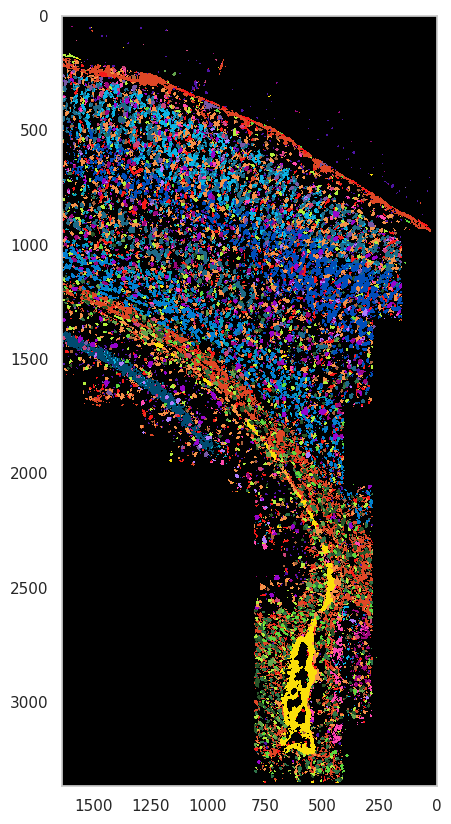

In [35]:
celltype_colors = [osmfish_ref_colors[cl] for cl in ds.transferred_cluster_labels]
plt.figure(figsize=[5, 10])
ds.plot_celltypes_map(colors=celltype_colors, rotate=2)

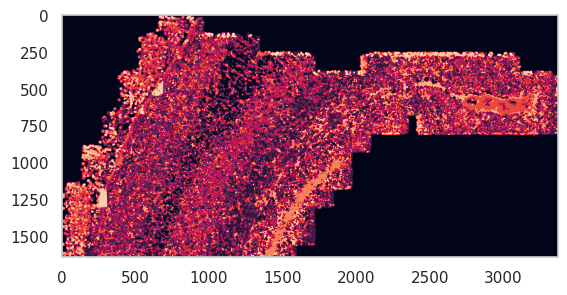

In [36]:
plt.imshow(np.squeeze(ds.celltype_maps))

In [37]:
osmfish_data_normalized = np.log1p(normalize(osmfish_data, norm='l1') * 1e4)
osmfish_centroids = np.zeros([len(osmfish_uniq_labels), len(osmfish_genes)])
for cl_idx, osmfish_cluster in enumerate(osmfish_uniq_labels):
    osmfish_centroids[cl_idx, :] = np.mean(osmfish_data_normalized[osmfish_clusters == osmfish_cluster, :], axis=0)

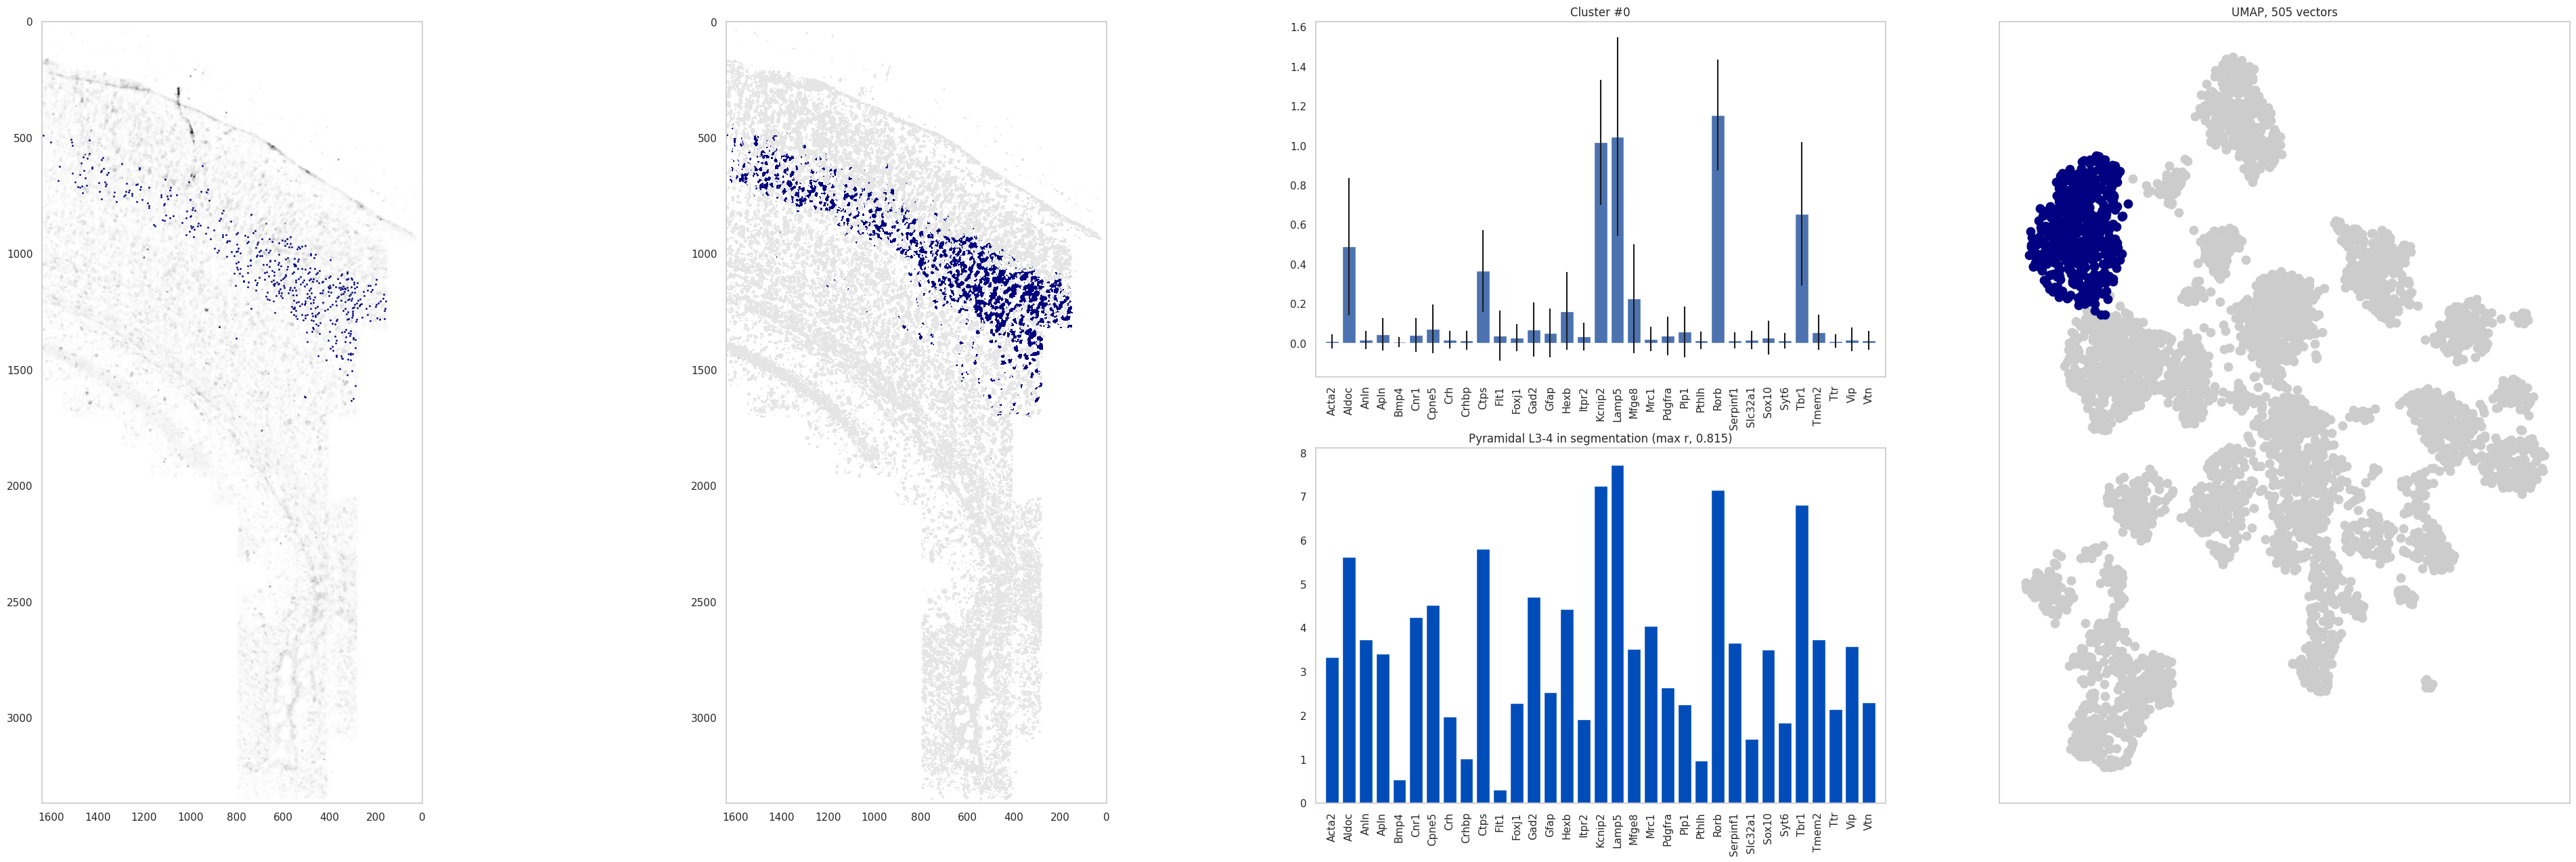

In [38]:
for i in range(np.max(ds.filtered_cluster_labels) + 1):
    plt.figure(figsize=[50, 15])
    ds.plot_diagnostic_plot(i, use_embedding='umap', known_signatures=[("segmentation", osmfish_uniq_labels, osmfish_centroids, osmfish_colors)], rotate=2)
    plt.show()
    break

In [39]:
denovo_labels = np.array(ds.transferred_cluster_labels, copy=True)

In [40]:
denovo_labels

array(['Pyramidal L3-4', 'Astrocyte Mfge8', 'Inhibitory Pthlh',
       'Pyramidal L6', 'Oligodendrocyte Precursor cells',
       'Astrocyte Gfap', 'Astrocyte Gfap', 'Pyramidal L2-3',
       'Pyramidal L5', 'Pyramidal L2-3 L5', 'Oligodendrocyte Mature',
       'Inhibitory Pthlh', 'Microglia', 'Inhibitory CP', 'Endothelial',
       'Inhibitory CP', 'Oligodendrocyte MF', 'Pyramidal L2-3 L5',
       'Inhibitory Crhbp', 'Astrocyte Gfap', 'Oligodendrocyte COP',
       'Astrocyte Mfge8', 'Inhibitory IC', 'Ependymal', 'Endothelial',
       'Inhibitory Vip', 'Astrocyte Mfge8', 'Inhibitory Kcnip2',
       'Hippocampus', 'Oligodendrocyte NF', 'Astrocyte Gfap',
       'Inhibitory Cnr1', 'Ependymal', 'Pyramidal L2-3 L5',
       'Astrocyte Gfap', 'Astrocyte Gfap', 'Astrocyte Mfge8',
       'Astrocyte Mfge8', 'Astrocyte Mfge8'], dtype=object)

In [41]:
# Below two lines are just examples, may not be accurate assignments
denovo_labels[0] = 'pyramidal L4'
denovo_labels[23] = 'C. Plexus'

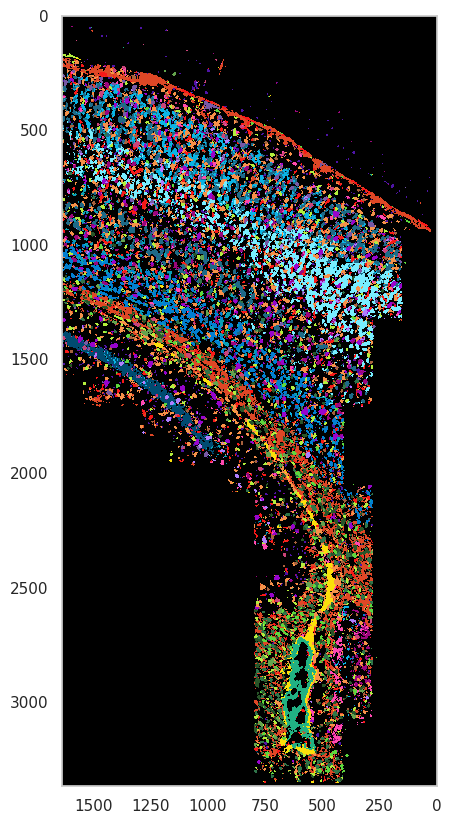

In [42]:
celltype_colors = [osmfish_ref_colors[cl] for cl in denovo_labels]
plt.figure(figsize=[5, 10])
ds.plot_celltypes_map(colors=celltype_colors, rotate=2)

In [43]:
import pickle
from skimage import filters

# Load DAPI image
with open('./data/raw/im_nuc_small.pickle', 'rb') as f:
    dapi = pickle.load(f)
dapi_small = dapi.T[:1640]

# Threshold DAPI image to create markers
dapi_threshold = filters.threshold_local(dapi_small, 35, offset=-0.0002)
dapi_thresh_im = (dapi_small > dapi_threshold).astype(np.uint8) * 255

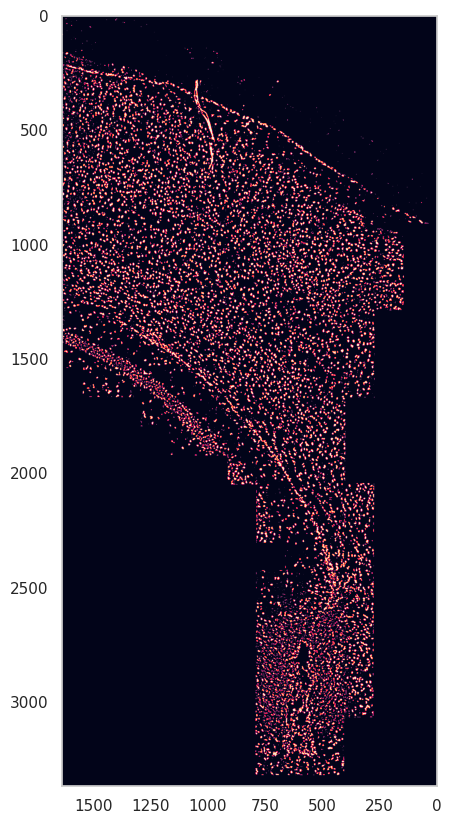

In [44]:
plt.figure(figsize=[20, 10])
plt.imshow(dapi_thresh_im.T)
plt.gca().invert_xaxis()

In [45]:
dapi_thresh_im.T

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### 9-2. Watershed 세그멘테이션 수행하기

In [46]:
# Run watershed segmentation of cell-type maps with DAPI as markers
# After running below, the segmentation data will be available as:
#  - Segmentations: ds.watershed_segments
#  - Cell-type map: ds.watershed_celltype_map
analysis.run_watershed(dapi_thresh_im)

Segmenting cell type #0...
Segmenting cell type #1...
Segmenting cell type #2...
Segmenting cell type #3...
Segmenting cell type #4...
Segmenting cell type #5...
Segmenting cell type #6...


Segmenting cell type #7...
Segmenting cell type #8...
Segmenting cell type #9...
Segmenting cell type #10...
Segmenting cell type #11...
Segmenting cell type #12...
Segmenting cell type #13...
Segmenting cell type #14...
Segmenting cell type #15...
Segmenting cell type #16...
Segmenting cell type #17...
Segmenting cell type #18...
Segmenting cell type #19...
Segmenting cell type #20...
Segmenting cell type #21...
Segmenting cell type #22...
Segmenting cell type #23...
Segmenting cell type #24...
Segmenting cell type #25...
Segmenting cell type #26...
Segmenting cell type #27...
Segmenting cell type #28...
Segmenting cell type #29...
Segmenting cell type #30...
Segmenting cell type #31...
Segmenting cell type #32...
Segmenting cell type #33...
Segmenting cell type #34...
Segmenting cell type #35...
Segmenting cell type #36...
Segmenting cell type #37...
Segmenting cell type #38...


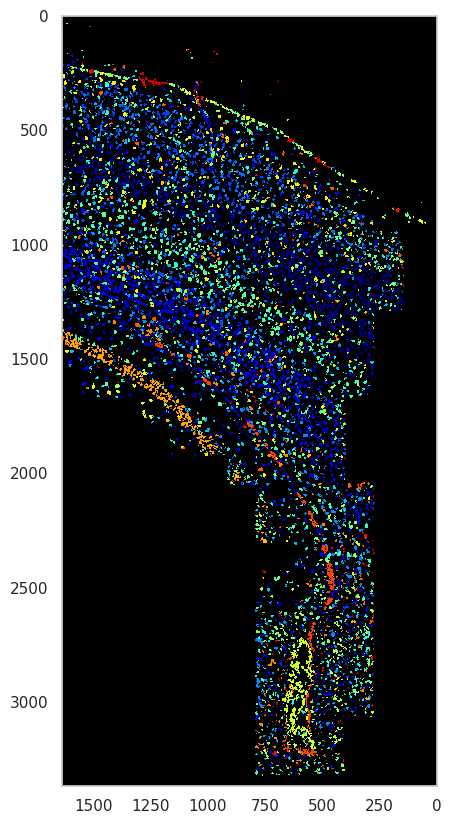

In [47]:
plt.figure(figsize=[5, 10])
#ds.plot_watershed_celltypes_map(colors=celltype_colors, rotate=2)
ds.plot_watershed_celltypes_map(rotate=2)

In [48]:
analysis.compute_cell_by_gene_matrix(df)

Generating spatial mRNA count matrix...


Computing cell-by-gene matrix...


In [49]:
ds.cell_by_gene_matrix

array([[ 0, 10,  0, ...,  0,  0,  0],
       [ 0, 12,  0, ...,  0,  0,  0],
       [ 0, 20,  1, ...,  0,  0,  0],
       ...,
       [ 0, 11,  2, ...,  1,  0,  1],
       [ 0,  0,  0, ...,  1,  0,  0],
       [ 1,  4,  1, ...,  1,  2,  1]])

In [50]:
analysis.bin_celltypemaps(step=10, radius=100)
analysis.find_domains(n_clusters=20, merge_remote=False, merge_thres=0.6, norm_thres=4500)

/home/ng4812/miniconda3/envs/ome/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


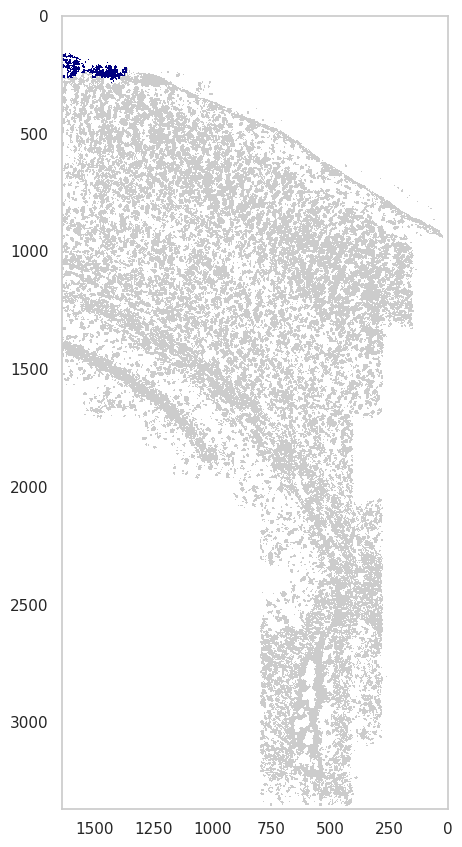

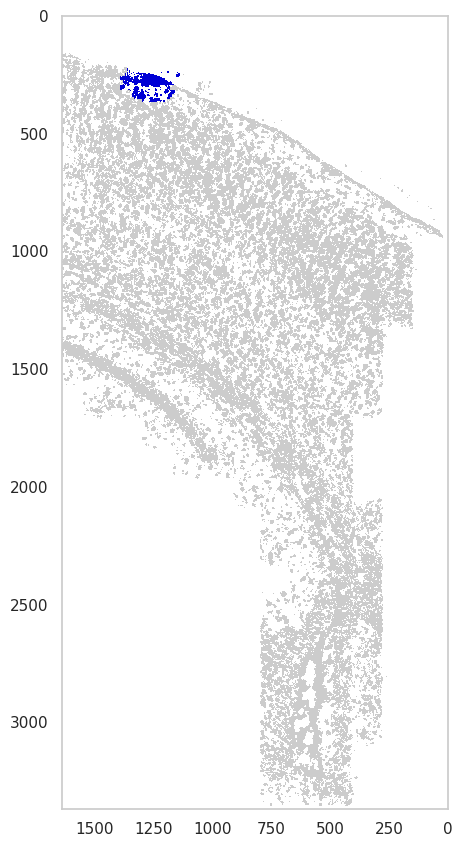

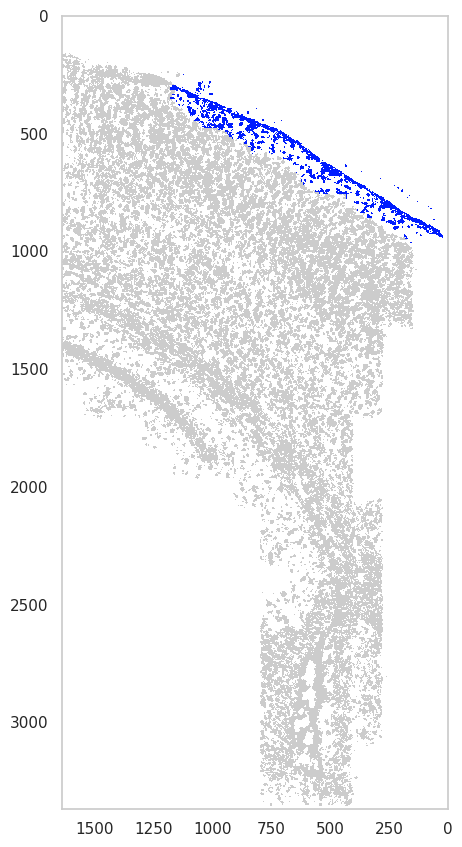

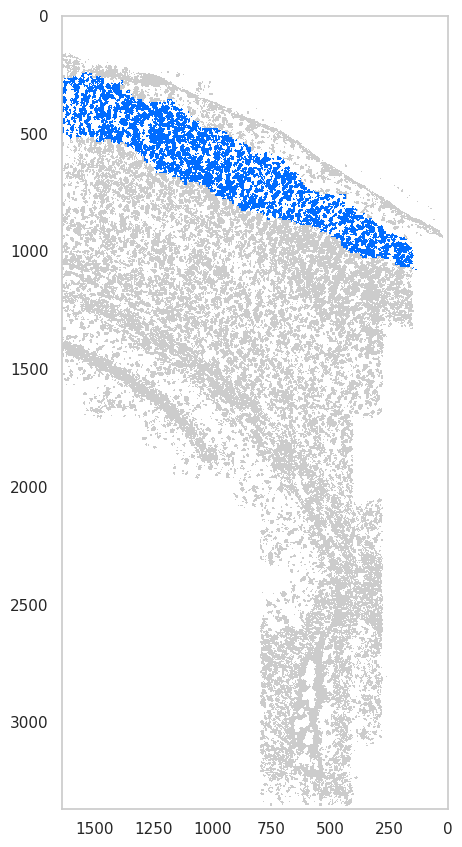

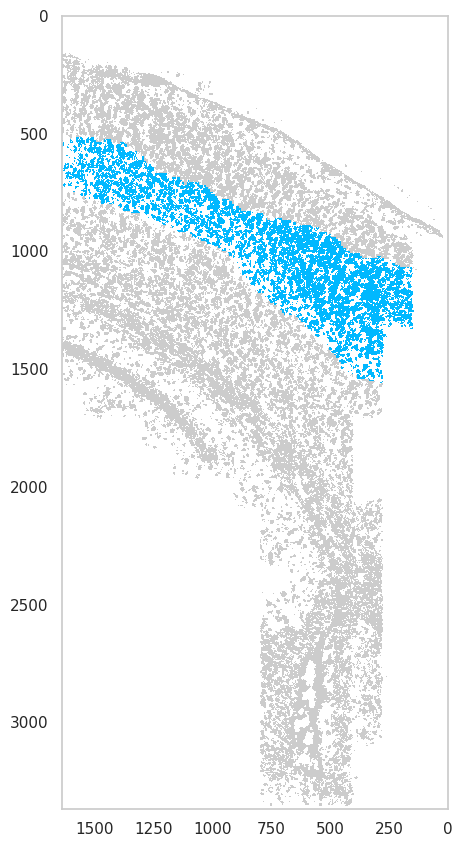

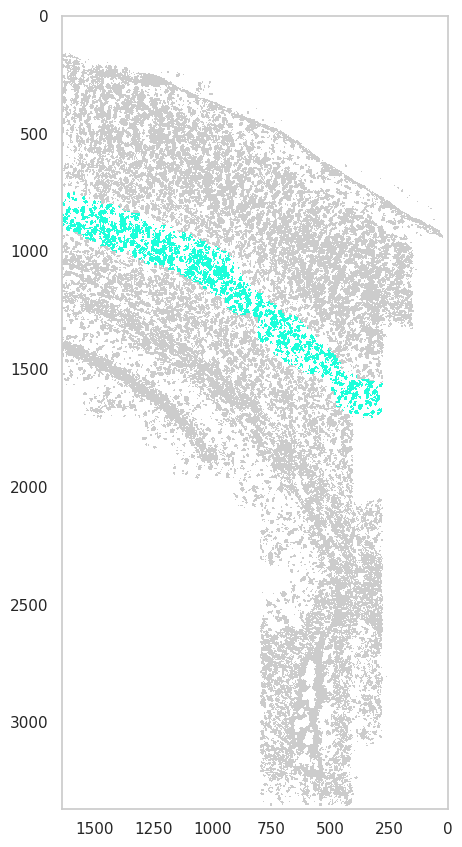

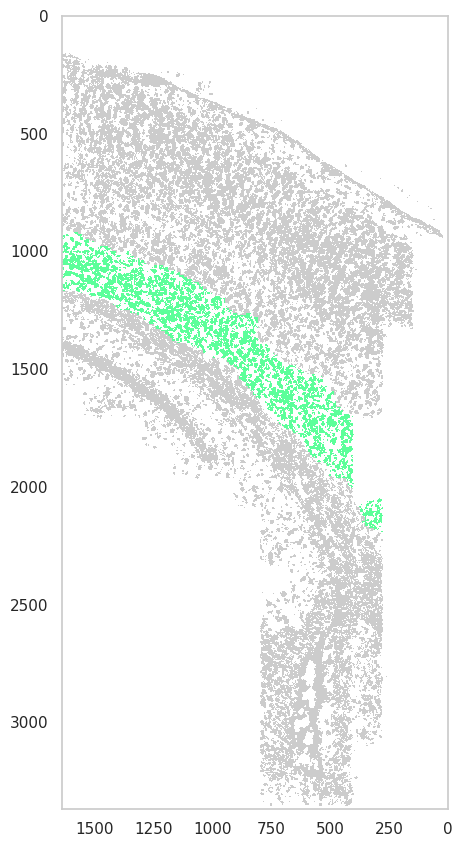

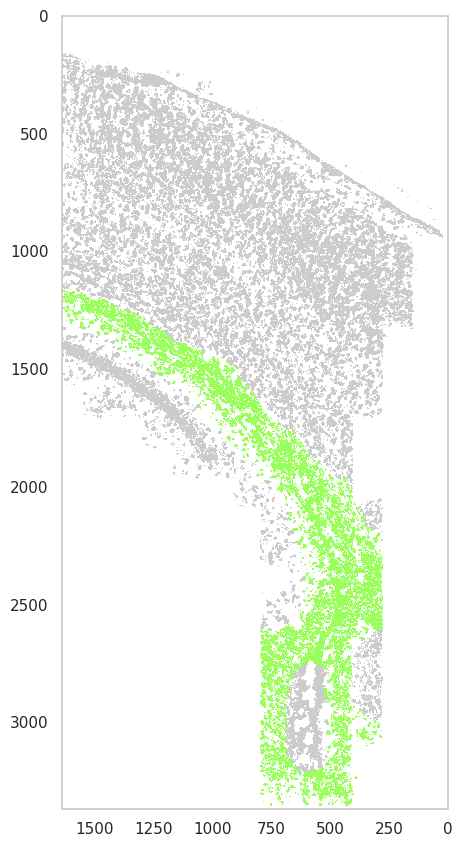

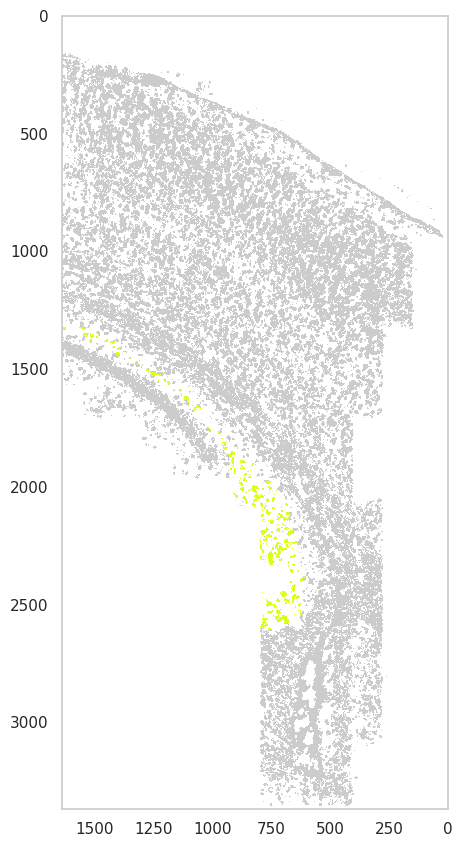

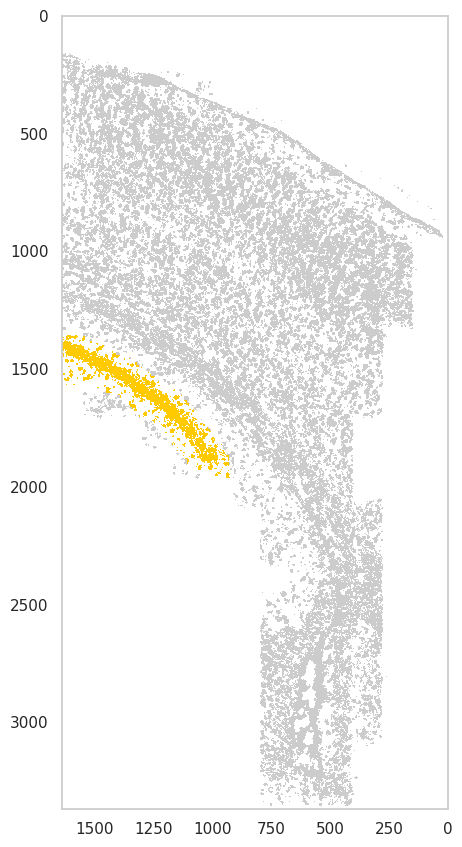

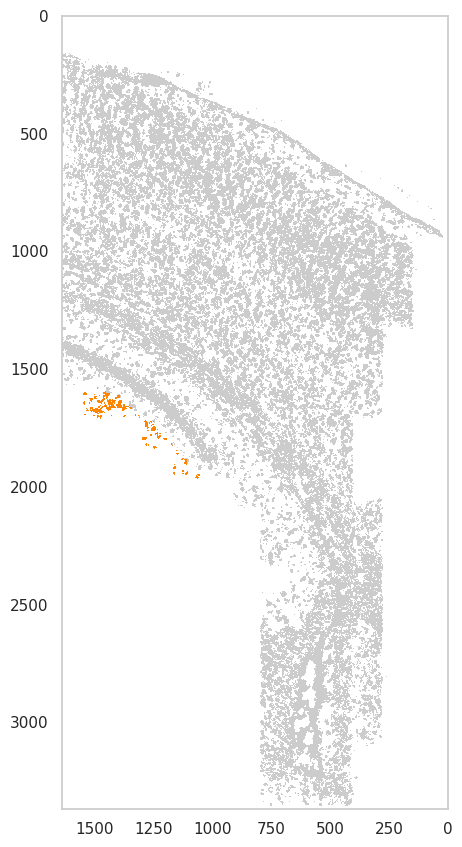

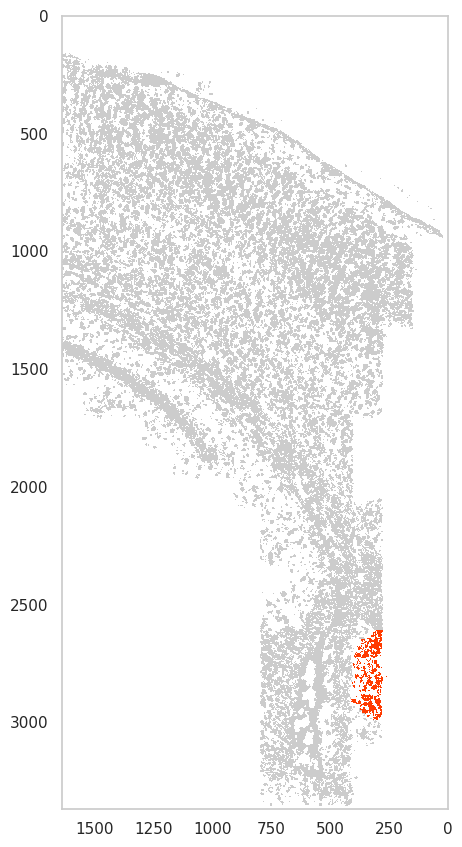

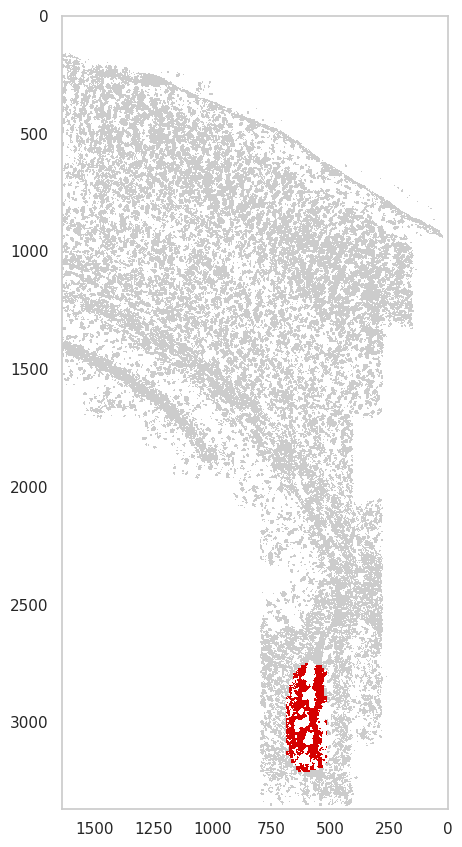

In [51]:
# Check found domains
from matplotlib.colors import ListedColormap
cmap_jet = plt.get_cmap('jet')
num_domains = np.max(ds.inferred_domains_cells) + 1
for domain_idx in range(num_domains):
    plt.figure(figsize=[5, 10.3])
    cmap = ListedColormap([cmap_jet(lbl_idx / num_domains) if domain_idx == lbl_idx else "#cccccc" for lbl_idx in range(num_domains)])
    ds.plot_domains(rotate=2, cmap=cmap)

In [52]:
excluded_domain_indices = []
merged_domain_indices = [[0, 1, 2], [7, 8, 10]]
analysis.exclude_and_merge_domains(excluded_domain_indices, merged_domain_indices)

In [53]:
domain_labels = [
    'Pia+Layer 1',
    'Layer 2/3',
    'Layer 4',
    'Layer 5',
    'Layer 6',
    'White matter',
    'Hippocampus',
    'IC CP',
    'Ventricle',
]

In [54]:
domain_colors = {
    'Pia+Layer 1': '#D44218',
    'Layer 2/3': '#85D7E4',
    'Layer 4': '#F6B813',
    'Layer 5': '#C6271B',
    'Layer 6': '#4987B9',
    'White matter': '#58BC06',
    'Hippocampus': '#104368',
    'Ventricle': '#F4D527',
    'IC CP': '#9C2387',
}

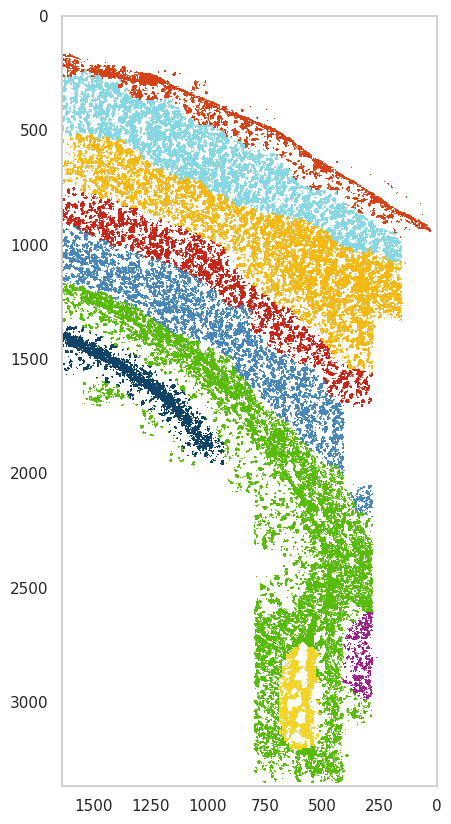

In [55]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=[5, 10])
cmap = ListedColormap([domain_colors[lbl] for lbl in domain_labels])
ds.plot_domains(rotate=2, cmap=cmap)